<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preporation" data-toc-modified-id="Data-Preporation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preporation</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

# LTV and ROMI Forecasting for Scanning Documents App

## Data Preporation

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
%pip install prophet
from prophet import Prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
#loading data 
data=pd.read_csv('test-case-data-analyst_3.csv')
data.head(5)

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2/19/2020,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2/17/2020,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2/18/2020,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2/18/2020,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2/16/2020,8803657


In [3]:
#studying the type of data and its qnt
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   product_id       114200 non-null  object
 1   quantity         114200 non-null  int64 
 2   is_trial_period  114200 non-null  bool  
 3   purchase_date    114200 non-null  object
 4   user_id          114200 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 3.6+ MB


## Data Preprocessing

In [4]:
#identifying gaps
data.isnull().sum()

product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64

In [5]:
#identifying duplicates
data.duplicated().sum()

84

In [6]:
#dropping duplicates
data=data.drop_duplicates()

In [7]:
#check
data.duplicated().sum()

0

In [8]:
#changing the data type of the purchase_date column
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

It is necessary to calculate the user's current LTV using cohort analysis (cohorting event - registration of a trial period, cohort represents the number of possible operations).

## Analysis

In [9]:
#adding a subscription column with the subscription price in case there was a payment
data.loc[data["is_trial_period"] == False, "subscription"] = 4.99
data.loc[data["is_trial_period"] == True, "subscription"] = 0
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,subscription
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,4.99
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,4.99
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,4.99
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,4.99
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,4.99


In [10]:
#adding a sum column with the total purchase amount
data['sum']=data['quantity']*data['subscription']
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,subscription,sum
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,4.99,4.99
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,4.99,4.99
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,4.99,4.99
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,4.99,4.99
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,4.99,4.99


In [11]:
#groupping the data
data_group=data.groupby('user_id').agg({'purchase_date': lambda date: (date.max() - date.min()).days,
                                        'product_id': lambda num: len(num),
                                        'quantity': lambda quant: quant.sum(),
                                        'sum': lambda price: price.sum()})

In [12]:
#renaming the columns
data_group.columns=['num_days','num_transactions','num_units','spent_money']
data_group.head()

,num_days,num_transactions,num_units,spent_money
user_id,,,,
404,7,2,2,4.99
5337,0,1,1,0.00
9010,21,4,4,14.97
19880,0,1,1,0.00
23403,22,4,4,14.97


In [13]:
#calculating the average order
data_group['avg_order_value']=data_group['spent_money']/data_group['num_transactions']
data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
user_id,,,,,
404,7,2,2,4.99,2.4950
5337,0,1,1,0.00,0.0000
9010,21,4,4,14.97,3.7425
19880,0,1,1,0.00,0.0000
23403,22,4,4,14.97,3.7425


In [14]:
#calculating purchase frequency
purchase_frequency=data_group['num_transactions'].sum()/data_group.shape[0]
purchase_frequency

1.8139852803255496

In [15]:
#calculating repeat purchase rate
repeat_rate=data_group[data_group.num_transactions > 1].shape[0]/data_group.shape[0]
repeat_rate

0.31113195250282155

In [16]:
#сalculating churn rate
churn_rate=1-repeat_rate
churn_rate

0.6888680474971784

In [17]:
#calculating Profit Margin
data_group['profit_margin']=data_group['spent_money']*0.5
data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
user_id,,,,,,
404,7,2,2,4.99,2.4950,2.495
5337,0,1,1,0.00,0.0000,0.000
9010,21,4,4,14.97,3.7425,7.485
19880,0,1,1,0.00,0.0000,0.000
23403,22,4,4,14.97,3.7425,7.485


In [18]:
#calculating Customer Value
data_group['CLV']=(data_group['avg_order_value']*purchase_frequency)/churn_rate

In [19]:
#calculating Customer Lifetime Value
data_group['cust_lifetime_value']=data_group['CLV']*data_group['profit_margin']

In [20]:
#check
data_group.head(5)

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
user_id,,,,,,,,
404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259
5337,0,1,1,0.00,0.0000,0.000,0.000000,0.000000
9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167
19880,0,1,1,0.00,0.0000,0.000,0.000000,0.000000
23403,22,4,4,14.97,3.7425,7.485,9.855066,73.765167


We need to predict LTV metric dynamics for the next six months.

In [21]:
#joining the data
new_data=data_group.merge(data,on='user_id')
new_data.head(5)

,user_id,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,product_id,quantity,is_trial_period,purchase_date,subscription,sum
0,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-03,0.00,0.00
1,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-10,4.99,4.99
2,5337,0,1,1,0.00,0.0000,0.000,0.000000,0.000000,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-17,0.00,0.00
3,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,4.99,4.99
4,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-27,0.00,0.00


In [22]:
#calculating the customer lifetime value for each date
df_1=new_data.groupby('purchase_date',as_index=False)\
        .agg({'cust_lifetime_value':'sum'})
df_1.rename(columns = {'purchase_date':'ds', 'cust_lifetime_value':'y'}, inplace = True)
df_1

,ds,y
0,2020-01-01,45436.337780
1,2020-01-02,58390.672025
2,2020-01-03,59571.734314
3,2020-01-04,63324.937247
4,2020-01-05,68269.076854
5,2020-01-06,52849.971264
6,2020-01-07,46229.684105
7,2020-01-08,87159.321429
8,2020-01-09,93235.931984
9,2020-01-10,98217.422525


In [23]:
#calling Prophet library
m = Prophet()
m.fit(df_1)

10:30:23 - cmdstanpy - INFO - Chain [1] start processing
10:30:23 - cmdstanpy - INFO - Chain [1] done processing


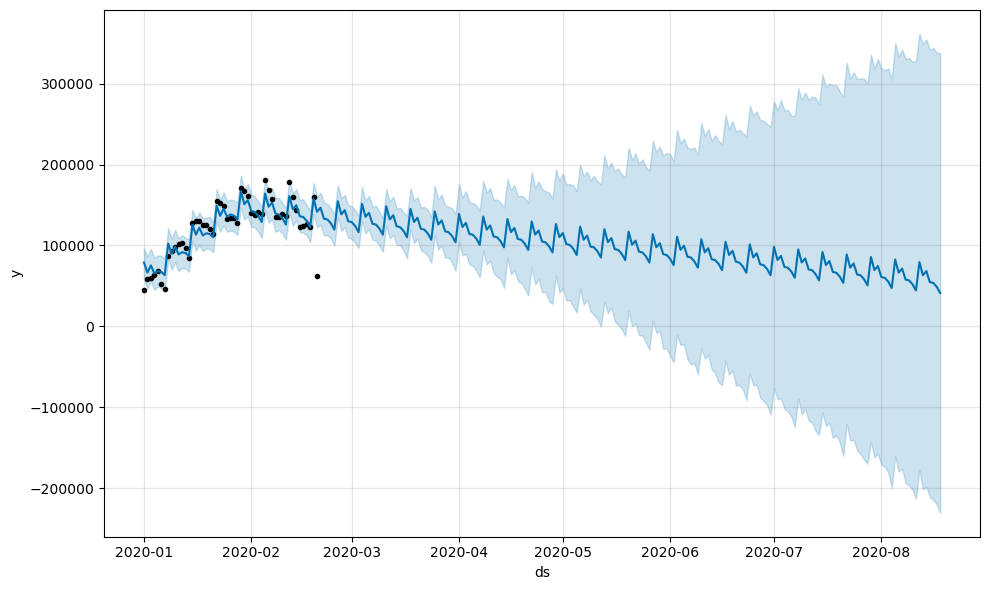

In [24]:
#forecasting 180 points, that is, six months
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)
m.plot(forecast);

We can see that according to the forecast LTV will decrease, but does not go in the negative.

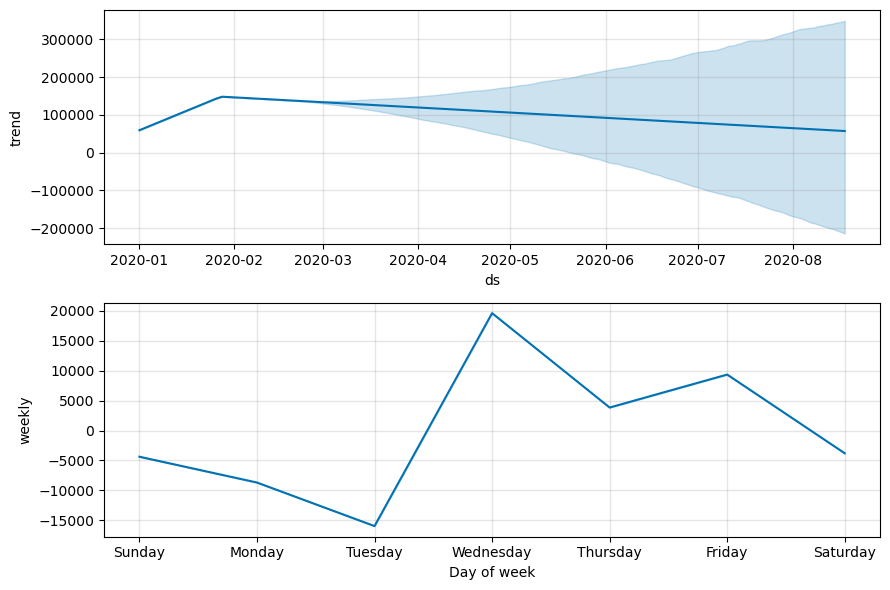

In [25]:
#forecasting
m.plot_components(forecast);

Besides, we need to calculate ROMI for the next 4 weeks and 6 months, if the cost of attracting a paying user is 6 USD (ROMI should be taken operational, not accounting, the goal is to find out whether investments will pay off).

In [26]:
#adding a column cac - the cost of attracting a paying user
new_data.loc[new_data["is_trial_period"]  == False, "cac"] = 6
new_data.loc[new_data["is_trial_period"] == True, "cac"] = 0

In [27]:
#check
new_data.head(5)

,user_id,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,product_id,quantity,is_trial_period,purchase_date,subscription,sum,cac
0,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-03,0.00,0.00,0.0
1,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-10,4.99,4.99,6.0
2,5337,0,1,1,0.00,0.0000,0.000,0.000000,0.000000,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-17,0.00,0.00,0.0
3,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,4.99,4.99,6.0
4,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-27,0.00,0.00,0.0


In [28]:
#calculating romi
new_data['romi']=new_data['cust_lifetime_value']/new_data['cac']

In [29]:
#check
new_data.head()

,user_id,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,product_id,quantity,is_trial_period,purchase_date,subscription,sum,cac,romi
0,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-03,0.00,0.00,0.0,inf
1,404,7,2,2,4.99,2.4950,2.495,6.570044,16.392259,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-10,4.99,4.99,6.0,2.732043
2,5337,0,1,1,0.00,0.0000,0.000,0.000000,0.000000,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-17,0.00,0.00,0.0,NaN
3,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,4.99,4.99,6.0,12.294195
4,9010,21,4,4,14.97,3.7425,7.485,9.855066,73.765167,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-27,0.00,0.00,0.0,inf


In [30]:
#highlighting only paying users
paid_data=new_data.query('is_trial_period==False')

In [31]:
#data preparation 
df_2=paid_data.groupby('purchase_date',as_index=False)\
        .agg({'romi':'sum'})
df_2.rename(columns = {'purchase_date':'ds', 'romi':'y'}, inplace = True)
df_2

,ds,y
0,2020-01-01,33.467530
1,2020-01-02,15.026238
2,2020-01-03,17.485077
3,2020-01-04,22.767027
4,2020-01-07,40.395211
5,2020-01-08,7155.657049
6,2020-01-09,9121.297106
7,2020-01-10,9425.991480
8,2020-01-11,9903.695744
9,2020-01-12,10647.474999


In [32]:
#calling Prophet library
m_1 = Prophet()
m_1.fit(df_2)

10:30:24 - cmdstanpy - INFO - Chain [1] start processing
10:30:24 - cmdstanpy - INFO - Chain [1] done processing


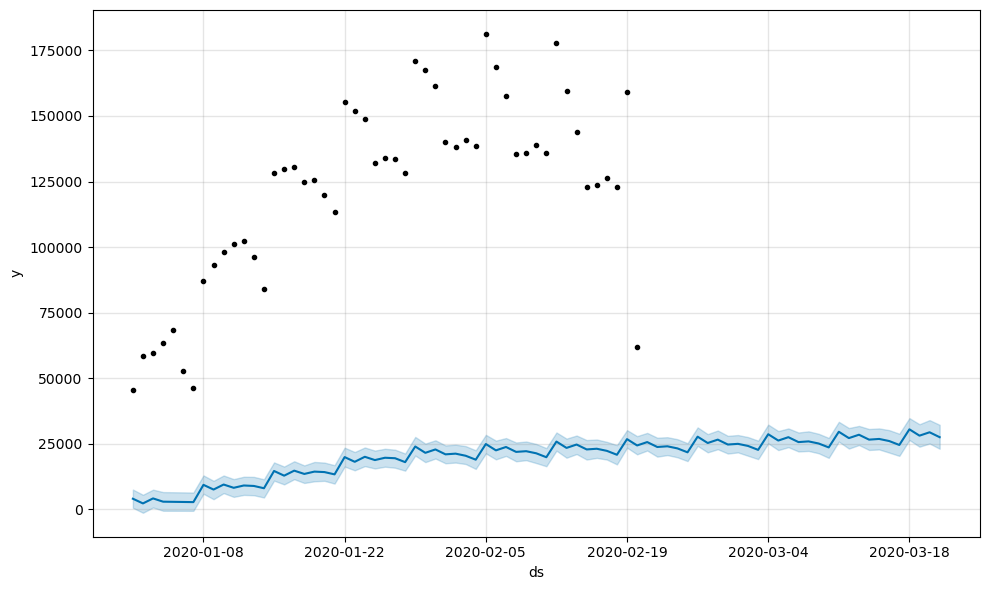

In [33]:
#forecasting 30 points - 1 month
future = m_1.make_future_dataframe(periods=30)
forecast = m_1.predict(future)
m.plot(forecast);

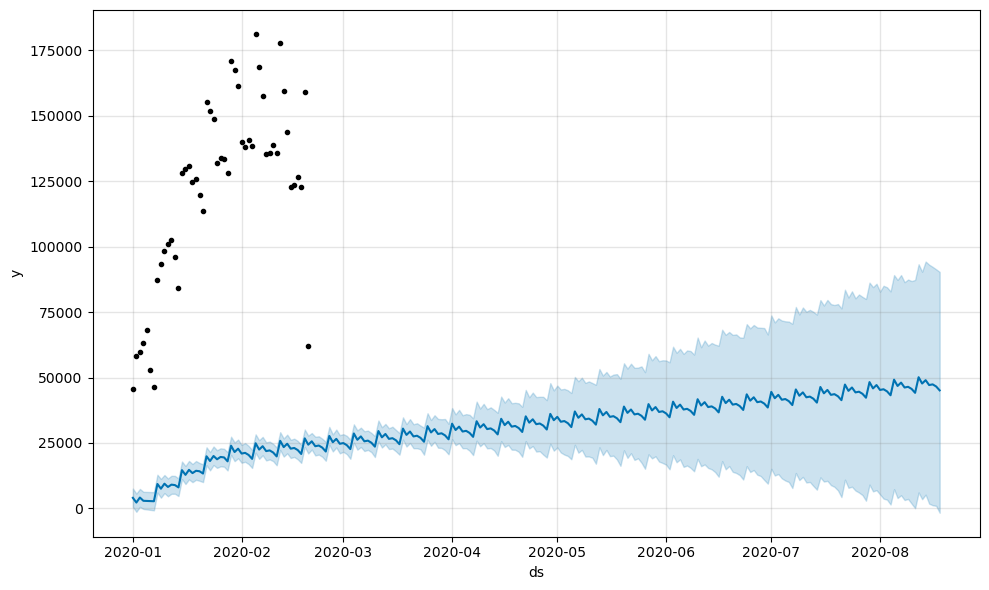

In [34]:
#forecasting 180 points - 6 months
future = m_1.make_future_dataframe(periods=180)
forecast = m_1.predict(future)
m.plot(forecast);

As can be noted, ROMI is also gradually increasing

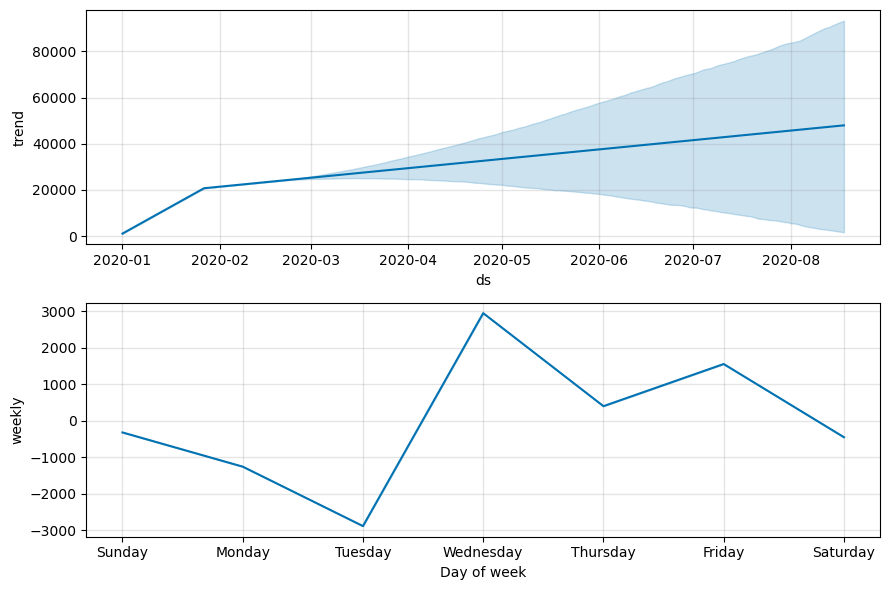

In [35]:
#forecasting
m_1.plot_components(forecast);